In [1]:
%matplotlib inline

import os, sys
sys.path.append("/home/matthew/lscsoft/.virtualenvs/lalapps_knope_O2/lib/python2.7/site-packages")

import numpy as np
from scotchcorner import scotchcorner as sc
import lalapps.pulsarpputils as pppu

import subprocess as sp
import collections
import itertools
import json
from scipy import stats

In [2]:
postfileH1 = 'nest_0010_H1_post.hdf'
postfileL1 = 'nest_0010_L1_post.hdf'
postfileJoint = 'nest_0010_H1L1_post.hdf'

# create figure
ps = collections.OrderedDict()
ps['H0'] = r'$h_0$'
ps['COSIOTA'] = r'$\cos{\iota}$'
ps['PHI0'] = r'$\phi_0$ (rad)'
ps['PSI'] = r'$\psi$ (rad)'
ps['F0'] = r'$\Delta f_0$ (Hz)'
ps['F1'] = r'$\Delta \dot{f}$ (Hz/s)'
ps['RA'] = r'$\Delta \alpha$ (rad)'

# values at which the signal was injected
jf = open('stats.json', 'r')
d = json.load(jf)
jf.close()

injpar = d['Injection parameters']['H1']
hetpar = d['Heterodyne parameters']
hetvals = []
truths = []
for p in ps:
    if p == 'RA':
        p += '_RAD'
    injval = injpar[p]

    if p not in hetpar:
        hetvals.append(0.)
    else:
        hetvals.append(hetpar[p])

    truths.append(injval - hetvals[-1])

H1samps = []
L1samps = []
Jointsamps = []
pH1, zH1, nH1 = pppu.pulsar_nest_to_posterior(postfileH1)
pL1, zL1, nL1 = pppu.pulsar_nest_to_posterior(postfileL1)
pJ, zJ, nJ = pppu.pulsar_nest_to_posterior(postfileJoint)
for i, p in enumerate(ps):
    H1samps.append(pH1[p].samples-hetvals[i])
    L1samps.append(pL1[p].samples-hetvals[i])
    Jointsamps.append(pJ[p].samples-hetvals[i])

H1samps = np.array(H1samps).squeeze().T
L1samps = np.array(L1samps).squeeze().T
Jointsamps = np.array(Jointsamps).squeeze().T

Read columns ['COSIOTA', 'F0', 'F1', 'H0', 'PHI0', 'PSI', 'RA', 'deltalogL', 'deltaloglH1', 'logL', 'logPrior', 'logw', 'C22', 'CGW', 'HVECTORY', 'C21', 'HVECTORX', 'PHI0VECTOR', 'PHI0SCALAR', 'PMDEC', 'PEPOCH', 'PMRA', 'HPLUS', 'I31', 'PHI22', 'HSCALARL', 'POSEPOCH', 'DIST', 'I21', 'PSITENSOR', 'IOTA', 'HSCALARB', 'PHI0TENSOR', 'HCROSS', 'COSTHETA', 'DEC', 'PX', 'PHI21', 'FREQNUM', 'Q22', 'df', 'THETA', 'F1_FIXED', 'PSIVECTOR', 'F0_FIXED', 'PSISCALAR', 'LAMBDA']
Read columns ['COSIOTA', 'F0', 'F1', 'H0', 'PHI0', 'PSI', 'RA', 'deltalogL', 'deltaloglL1', 'logL', 'logPrior', 'logw', 'C22', 'CGW', 'HVECTORY', 'C21', 'HVECTORX', 'PHI0VECTOR', 'PHI0SCALAR', 'PMDEC', 'PEPOCH', 'PMRA', 'HPLUS', 'I31', 'PHI22', 'HSCALARL', 'POSEPOCH', 'DIST', 'I21', 'PSITENSOR', 'IOTA', 'HSCALARB', 'PHI0TENSOR', 'HCROSS', 'COSTHETA', 'DEC', 'PX', 'PHI21', 'FREQNUM', 'Q22', 'df', 'THETA', 'F1_FIXED', 'PSIVECTOR', 'F0_FIXED', 'PSISCALAR', 'LAMBDA']
Read columns ['COSIOTA', 'F0', 'F1', 'H0', 'PHI0', 'PSI', 'RA', 

In [3]:
# output the coherent signal versus noise odds
print("log10 Coherent signal vs noise odds = %.2f" % ((zJ-nJ)/np.log(10.)))

# output the coherent signal versus incoherent or noise odds
ifossn = [{'s': zH1, 'n': nH1}, {'s': zL1, 'n': nL1}]
combs = [list(i) for i in itertools.product(['s', 'n'], repeat=2)]
incoherentcombs = -np.inf
for comb in combs:
    combsum = 0.
    for i, cval in enumerate(comb):
        combsum += ifossn[i][cval]
    incoherentcombs = np.logaddexp(incoherentcombs, combsum)

bcins = zJ - incoherentcombs
print("log10 Coherent signal vs incoherent signal or noise odds = %.2f" % (bcins/np.log(10.)))

log10 Coherent signal vs noise odds = 23.77
log10 Coherent signal vs incoherent signal or noise odds = 6.25


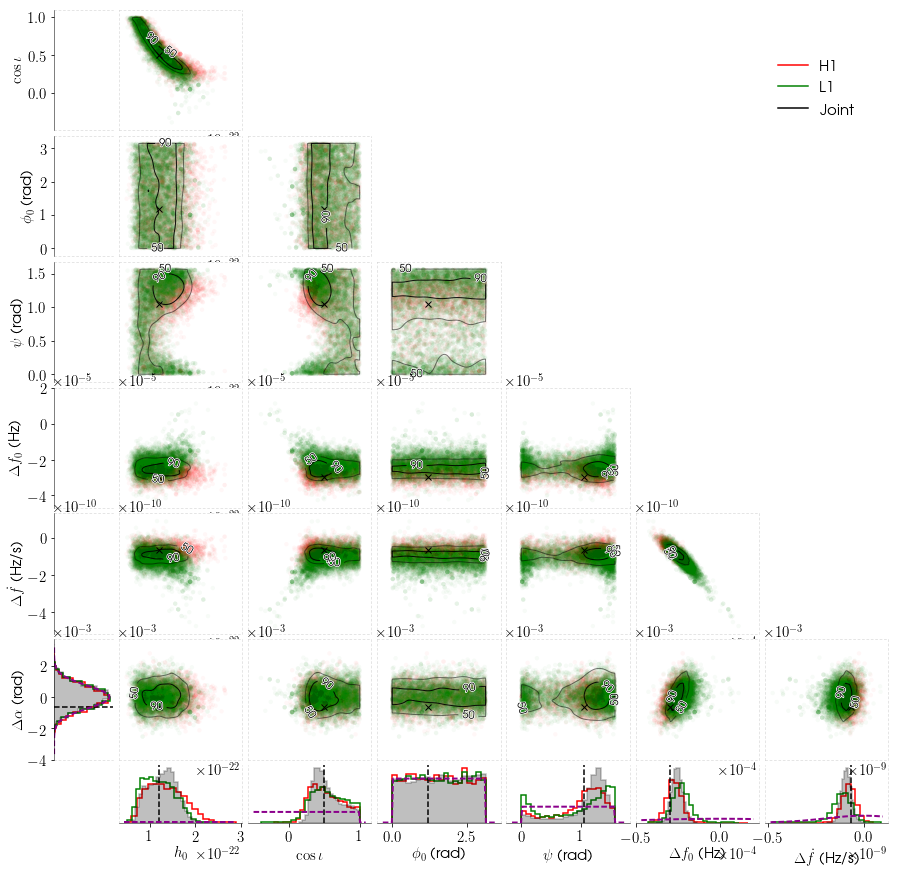

In [5]:
priors = {}
priors[ps['H0']] = stats.uniform(0., 1e-20)
priors[ps['COSIOTA']] = stats.uniform(-1., 2.)
priors[ps['PHI0']] = stats.uniform(0., np.pi)
priors[ps['PSI']] = stats.uniform(0., np.pi/2.)
priors[ps['F0']] = stats.norm(0., 5e-5)
priors[ps['RA']] = stats.norm(0., 0.000727220521664)
priors[ps['F1']] = stats.norm(0., 2e-10)

histops = {'histtype': 'step', 'color': 'r', 'edgecolor': 'r', 'linewidth': 1.5, 'alpha': 1.0}

limits = [(0., None), (None, 1.), (0., np.pi), (0., np.pi/2.), (None, None), (None, None), (None, None)]

spp = sc(H1samps, bins=20, ratio=2, labels=ps.values(), datatitle='H1', showlims='both', hist_kwargs=histops,
         showcontours=False, showpoints=True, scatter_kwargs={'alpha': 0.03}, limits=limits,
         thinpoints=3)

histops = {'histtype': 'step', 'color': 'g', 'edgecolor': 'g', 'linewidth': 1.5, 'alpha': 1.0}
spp.add_data(L1samps, hist_kwargs=histops, datatitle='L1', scatter_kwargs={'alpha': 0.03}, showcontours=False,
             limits=limits)

histops = {'histtype': 'stepfilled', 'color': 'k', 'edgecolor': 'k', 'linewidth': 1.5, 'alpha': 0.25}
contourops = {'colors': 'black'}
spp.add_data(Jointsamps, hist_kwargs=histops, datatitle='Joint', scatter_kwargs={'alpha': 0.03}, showcontours=True,
             limits=limits, contour_limits=limits, contour_kwargs=contourops, truths=truths, showpoints=False,
             truths_kwargs={'color': 'k', 'linestyle': '--'})

# plot priors
for i, lab in enumerate(ps.values()):
    ax = spp.get_axis(lab)
    
    if i < len(ps.values())-1:
        lims = ax.get_xlim()
    else:
        lims = ax.get_ylim()

    pvals = np.linspace(lims[0], lims[1], 100)
    pdf = priors[lab].pdf(pvals)

    if i < len(ps.values())-1:
        ax.plot(pvals, pdf, color='darkmagenta', linestyle='--', lw=2)
    else:
        ax.plot(pdf, pvals, color='darkmagenta', linestyle='--', lw=2)

In [6]:
# output the plot
spp.savefig('ffdot_inj2.pdf')
spp.fig.savefig('ffdot_inj2.png', dpi=300)
p = sp.Popen('pdftops -eps ffdot_inj2.pdf', shell=True)
p.communicate()

caption = r"""\label{fig:ffdot_inj2}
Posterior probability distributions for the recovered parameters of a simulated signal injected into Gaussian
noise for two LIGO detectors (H1 and L1). The search included the parameters $f_0$, $\dot{f}$, and $\alpha$. The
individual injected SNRs were 7.3 and 8.5 for H1 and L1 respectively, with a coherent SNR of 11.2. The black
vertical dashed lines show the true simulated parameter values, whilst the dashed dark purple lines show the
priors.
"""

fp = open('caption.tex', 'w')
fp.write(caption)
fp.close()